# Data Leakage

* Data leakage (or leakage) happens when your training data contains information about the target, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production.

In other words, leakage causes a model to look accurate until you start making decisions with the model, and then the model becomes very inaccurate.

There are two main types of leakage: target leakage and train-test contamination.

1. Trget leakage

* occurs when your predictors include data that will not be available at the time you make predictions. It is important to think about target leakage in terms of the timing or chronological order that data becomes available, not merely whether a feature helps make good predictions.

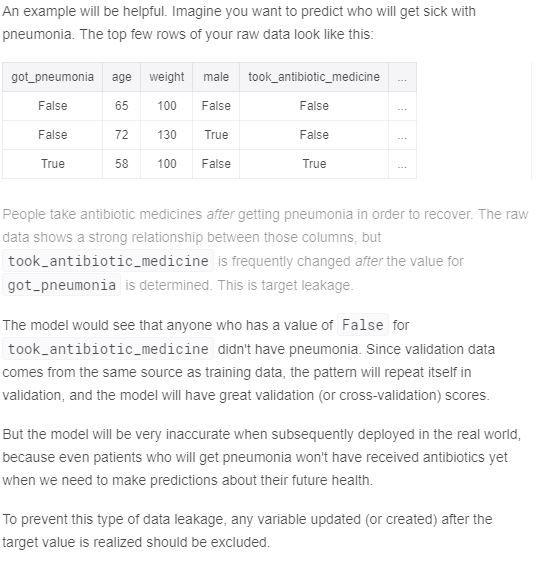

In [2]:
from IPython.display import Image
Image(filename='pneumonia.JPG')

2. Train-Test Contamination

A different type of leak occurs when you aren't careful to distinguish training data from validation data.

Recall that validation is meant to be a measure of how the model does on data that it hasn't considered before. You can corrupt this process in subtle ways if the validation data affects the preprocessing behavior. This is sometimes called train-test contamination.

For example, imagine you run preprocessing (like fitting an imputer for missing values) before calling train_test_split(). The end result? Your model may get good validation scores, giving you great confidence in it, but perform poorly when you deploy it to make decisions.

After all, you incorporated data from the validation or test data into how you make predictions, so the may do well on that particular data even if it can't generalize to new data. This problem becomes even more subtle (and more dangerous) when you do more complex feature engineering.

If your validation is based on a simple train-test split, exclude the validation data from any type of fitting, including the fitting of preprocessing steps. This is easier if you use scikit-learn pipelines. When using cross-validation, it's even more critical that you do your preprocessing inside the pipeline!

In [5]:
import pandas as pd

data=pd.read_csv('AER_credit_card_data.csv', true_values=['yes'], false_values=['no'])

* true_values : list, optional

Values to consider as True.

* false_values : list, optional

Values to consider as False

In [6]:
#target
y=data.card

In [7]:
X=data.drop(['card'], axis=1)

In [8]:
X.shape

(1319, 11)

In [10]:
X.head()

,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,0,37.66667,4.5200,0.033270,124.983300,True,False,3,54,1,12
1,0,33.25000,2.4200,0.005217,9.854167,False,False,3,34,1,13
2,0,33.66667,4.5000,0.004156,15.000000,True,False,4,58,1,5
3,0,30.50000,2.5400,0.065214,137.869200,False,False,0,25,1,7
4,0,32.16667,9.7867,0.067051,546.503300,True,False,2,64,1,5


It is a small dataset so we can use cross-validation to ensure accurate measures of model quality.

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [12]:
my_pipeline=make_pipeline(RandomForestClassifier(n_estimators=100))
cv_scores=cross_val_score(my_pipeline,X,y,cv=5,scoring='accuracy')

In [13]:
print('Cross_validation score : ')
print(cv_scores.mean())

Cross_validation score : 
0.9795165841643352


With experience, you'll find that it's very rare to find models that are accurate 98% of the time. It happens, but it's uncommon enough that we should inspect the data more closely for target leakage.

Here is a summary of the data, which you can also find under the data tab:

* card: 1 if credit card application accepted, 0 if not
* reports: Number of major derogatory reports
* age: Age n years plus twelfths of a year
* income: Yearly income (divided by 10,000)
* share: Ratio of monthly credit card expenditure to yearly income
* expenditure: Average monthly credit card expenditure
* owner: 1 if owns home, 0 if rents
* selfempl: 1 if self-employed, 0 if not
* dependents: 1 + number of dependents
* months: Months living at current address
* majorcards: Number of major credit cards held
* active: Number of active credit accounts

A few variables look suspicious. For example, does expenditure mean expenditure on this card or on cards used before appying?

In [14]:
expend_cardholders=X.expenditure[y]
expend_noncardholders=X.expenditure[~y]

In [15]:
print('Fraction of those who did not receive a card and had no expenditures:')
print((expend_noncardholders==0).mean())
print('Fraction of those who received a card and had no expenditures:')
print((expend_cardholders==0).mean())

Fraction of those who did not receive a card and had no expenditures:
1.0
Fraction of those who received a card and had no expenditures:
0.020527859237536656


As shown above, everyone who did not receive a card had no expenditures, while only 2% of those who received a card had no expenditures. It's not surprising that our model appeared to have a high accuracy. But this also seems to be a case of target leakage, where expenditures probably means expenditures on the card they applied for.

Since share is partially determined by expenditure, it should be excluded too. The variables active and majorcards are a little less clear, but from the description, they sound concerning. In most situations, it's better to be safe than sorry if you can't track down the people who created the data to find out more.

We would run a model without target leakage as follows:

In [16]:
potential_leaks=['expenditure','share','active','majorcards']
X_new=X.drop(potential_leaks, axis=1)

In [17]:
cv_scores=cross_val_score(my_pipeline, X_new,y,cv=5,scoring='accuracy')

In [19]:
print(cv_scores.mean())

0.834712165778598


We can assume that our model will be 80 % correct after new data comes in from new applications.